In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in all the names
names = open('names.txt', 'r').read().splitlines()
print('total no. of names', len(names))
names[:8]

total no. of names 32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):  
  X, Y = [], []
  
  for w in names:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
for x, y in zip(Xtr[:10], Ytr[:10]):
    print(f"{''.join(itos[ix.item()] for ix in x)} --> {itos[y.item()]}")

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o


In [58]:
class Linear:
    """
    Implementation of linear layer in a neural network.
    """
    def __init__(self, fan_in, fan_out, bias=True):
        """
        fan_in : No. of input features.
        fan_out : No. of output features.
        bias : Required bias term. No requiement if batch normalization.
        """
        self.weight = torch.randn((fan_in,  fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, X):
        self.out = X @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] if self.bias is None else [self.weight, self.bias]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum                # Momentum for calculating the running mean and running variance.
        self.training = training                # If normalization is done during training.
        self.gamma = torch.ones(dim)       # The scaling parameter of batch normalization.
        self.beta = torch.zeros(dim)       # The shifting parameter of batch normalization.
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, X):
        # Calculating the forward pass
        if self.training:
            xmean = X.mean(0, keepdim=True)
            xvar = X.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (X-xmean)/torch.sqrt(xvar+self.eps)    # Normalize to unit variance.
        self.out = self.gamma * xhat + self.beta

        # Update the buffers (xmean and xvar)
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [80]:
class Embeddings:
    def __init__(self, num_embd: int, embedding_dim: int):
        self.weight = torch.randn((num_embd, embedding_dim))

    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        self.parameters = [p for layer in self.layers for p in layer.parameters()]

In [59]:
n_hidden = 200
n_embd = 10
g = torch.Generator().manual_seed(2147483647)

In [82]:
C = torch.randn((vocab_size, n_embd),   generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [83]:
max_steps = 2000
batch_size = 32
lossi = []
stepi = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 200 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   2000: 3.6994
    200/   2000: 2.7326
    400/   2000: 2.5916
    600/   2000: 2.4721
    800/   2000: 2.4117
   1000/   2000: 2.6643
   1200/   2000: 2.6753
   1400/   2000: 2.5499
   1600/   2000: 2.5672
   1800/   2000: 2.5120


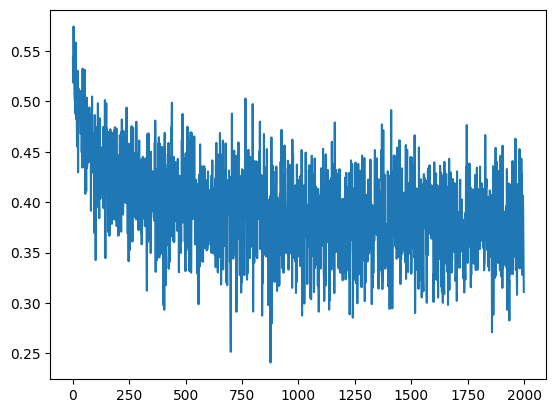

In [55]:
plt.plot(lossi)

In [56]:
# To bring the layers (Batch norm layer) out of training mode.
for layer in layers:
    layer.training = False

In [63]:
# Validation loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ layers[0].weight
  hpreact = layers[1].gamma * (hpreact - layers[1].running_mean) * (layers[1].running_var + 1e-5)**-0.5 + layers[1].beta
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ layers[3].weight # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.609940767288208
val 2.6124579906463623


In [73]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
         x = layer(x)
      logits = x
      probs = F.softmax(x, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

iuah.
dinra.
bre.
ana.
java.
miejenreluon.
grawy.
sameyrayn.
kdon.
ilesan.
ella.
olchabdrenna.
ahberuyeana.
zalsi.
dabda.
birs.
aza.
touvia.
vol.
breyca.


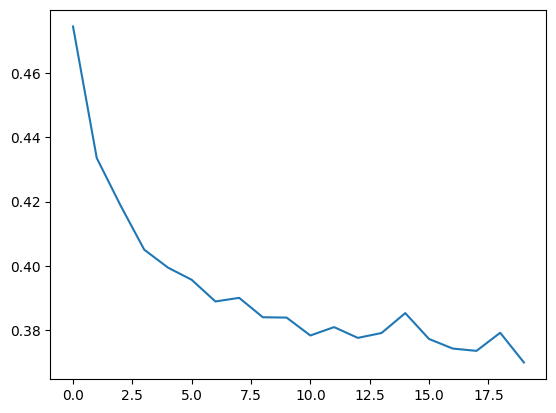

In [78]:
plt.plot((torch.tensor(lossi).view(20, 100).mean(1)))

# Further organinising(torhifying) the code.

In [96]:
model = Sequential([
  Embeddings(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [97]:
max_steps = 2000
batch_size = 32
lossi = []
stepi = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 200 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   2000: 3.5242
    200/   2000: 2.8128
    400/   2000: 2.5442
    600/   2000: 2.4637
    800/   2000: 2.5812
   1000/   2000: 2.3195
   1200/   2000: 2.4415
   1400/   2000: 2.5533
   1600/   2000: 2.2767
   1800/   2000: 1.9623


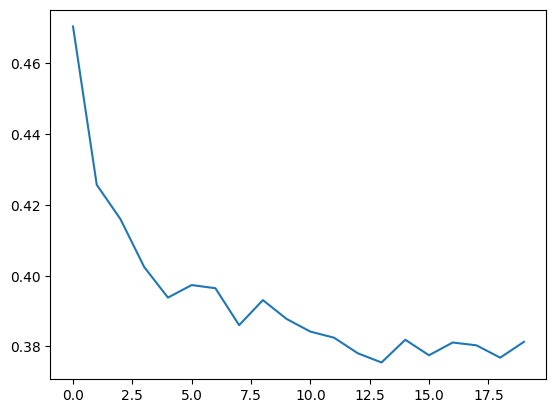

In [98]:
plt.plot((torch.tensor(lossi).view(20, 100).mean(1)))

In [99]:
# Validation loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # emb = C[x] # (N, block_size, n_embd)
  # embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # hpreact = embcat @ layers[0].weight
  # hpreact = layers[1].gamma * (hpreact - layers[1].running_mean) * (layers[1].running_var + 1e-5)**-0.5 + layers[1].beta
  # h = torch.tanh(hpreact) # (N, n_hidden)
  # logits = h @ layers[3].weight # (N, vocab_size)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.3738744258880615
val 2.3728926181793213


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
    #   # forward pass
    #   emb = C[torch.tensor([context])] # (1,block_size,d)
    #   x = emb.view(emb.shape[0], -1)
    #   for layer in layers:
    #      x = layer(x)
    #   logits = x
      logits = model()
      probs = F.softmax(x, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))